# CNN을 활용한 이미지 인식: CIFAR

In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

import numpy as np
import matplotlib.pyplot as plt

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# 기본 폰트 설정
# 윈도우에서는 "malgun.ttf" 혹은 "NanumBarunGothic.ttf" 등을 사용할 수 있다. 맥에서는 "AppleGothic.ttf"
# plt.rcParams['font.family'] = font_name  

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'


# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

### GPU 확인하기

In [4]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## CNN의 처리 개요

In [5]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  
    train = True,  
    download = True, 
    transform = transform)

image, label = train_set[0]  # torch.Size([1, 28, 28])
image = image.view(1,1,28,28)

In [6]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3) 
print("conv1.weight.shape = ", conv1.weight.shape) # [outputs, channel, kernel size (3x3)]
print("="*50)
print("conv1.weight = \n", conv1.weight)
print("conv1.bias = ", conv1.bias)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)
# conv1.bias.data = torch.tensor([0]).float()

conv1.weight.shape =  torch.Size([1, 1, 3, 3])
conv1.weight = 
 Parameter containing:
tensor([[[[ 0.3296,  0.1297, -0.0288],
          [-0.2568,  0.0417, -0.2045],
          [-0.1488, -0.0146, -0.0972]]]], requires_grad=True)
conv1.bias =  Parameter containing:
tensor([0.0550], requires_grad=True)


Parameter containing:
tensor([0.], requires_grad=True)

### nn.Conv2d 와 nn.MaxPool2d

In [7]:
# CNN 모델 전반 부분, 레이어 함수 정의
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
#                 stride=1, padding=0, dilation=1, groups=1, 
#                 bias=True, padding_mode='zeros', device=None, dtype=None)

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

print("conv1.weight.shape = \n", conv1.weight.shape)

conv1.weight.shape = 
 torch.Size([32, 3, 3, 3])


In [8]:
# conv1 확인
print("conv1")
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape) # torch.Size([32, 3, 3, 3]), (N, C, H, W) 
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print("="*50)
print("conv2")
print(conv2.weight.shape)
print(conv2.bias.shape)

conv1
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
conv2
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [9]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]

# weight[0]의 shape과 값 확인
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.0341 -0.0835 -0.0946]
  [-0.0964 -0.0781  0.1388]
  [ 0.0577 -0.1801  0.0212]]

 [[ 0.1895  0.1249 -0.0617]
  [-0.0647 -0.0435  0.0329]
  [-0.0708  0.0308  0.0145]]

 [[-0.0867  0.1903 -0.1253]
  [ 0.0952 -0.0064 -0.1541]
  [-0.167  -0.1065  0.1882]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.72225..3.2658262].


torch.Size([100, 3, 32, 32])


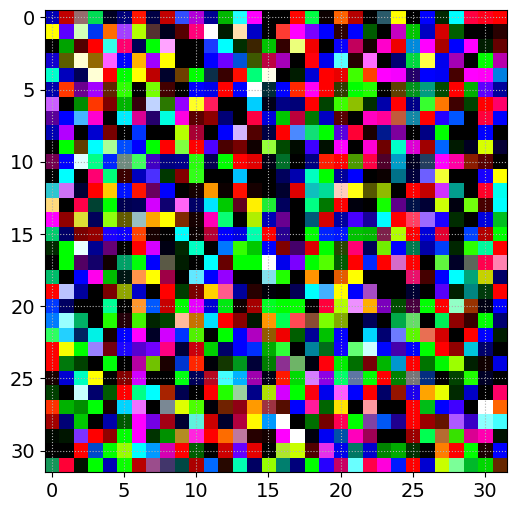

In [10]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

## image show
plt.imshow(inputs[0].permute(1, 2, 0))
plt.show()

In [11]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs) # input size = torch.Size([100, 3, 32, 32])
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [12]:
# 각 변수의 shape 확인

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [13]:
# conv1 = nn.Conv2d(3, 32, 3)
# relu = nn.ReLU(inplace=True)
# conv2 = nn.Conv2d(32, 32, 3)
# maxpool = nn.MaxPool2d((2, 2))

# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

# 동작 테스트
outputs = features(inputs)

In [14]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [15]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


### 데이터 준비

In [16]:
# Transforms의 정의

# 학습 데이터
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.flatten()),
])


# 검증 데이터용 : 정규화만 실시
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [17]:
# 데이터 취득용 함수 datasets

data_root = './data'

# 훈련 데이터셋 (FCN)
train_set1 = datasets.CIFAR10(
    root = data_root, 
    train = True, 
    download = True, 
    transform = transform1)

# 검증 데이터셋 (FCN)
test_set1 = datasets.CIFAR10(
    root = data_root, 
    train = False, 
    download = True, 
    transform = transform1)

# 훈련 데이터셋 (CNN)
train_set2 = datasets.CIFAR10(
    root =  data_root, 
    train = True, 
    download = True, 
    transform = transform2)

# 검증 데이터셋 (CNN)
test_set2 = datasets.CIFAR10(
    root = data_root, 
    train = False, 
    download = True, 
    transform = transform2)

### 데이터셋 확인

In [18]:
image1, label1 = train_set1[0] # 3 x 32 x 32 = [3072]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [19]:
# 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [20]:
# train_loader1에서 한 세트 가져오기
for images1, labels1 in train_loader1:
    break

# train_loader2에서 한 세트 가져오기
for images2, labels2 in train_loader2:
    break

# 
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


In [21]:
# 정답 라벨 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
# 데이터로더에서 처음 1세트를 가져오기
for images, labels in test_loader2:
    break

images.shape

torch.Size([100, 3, 32, 32])

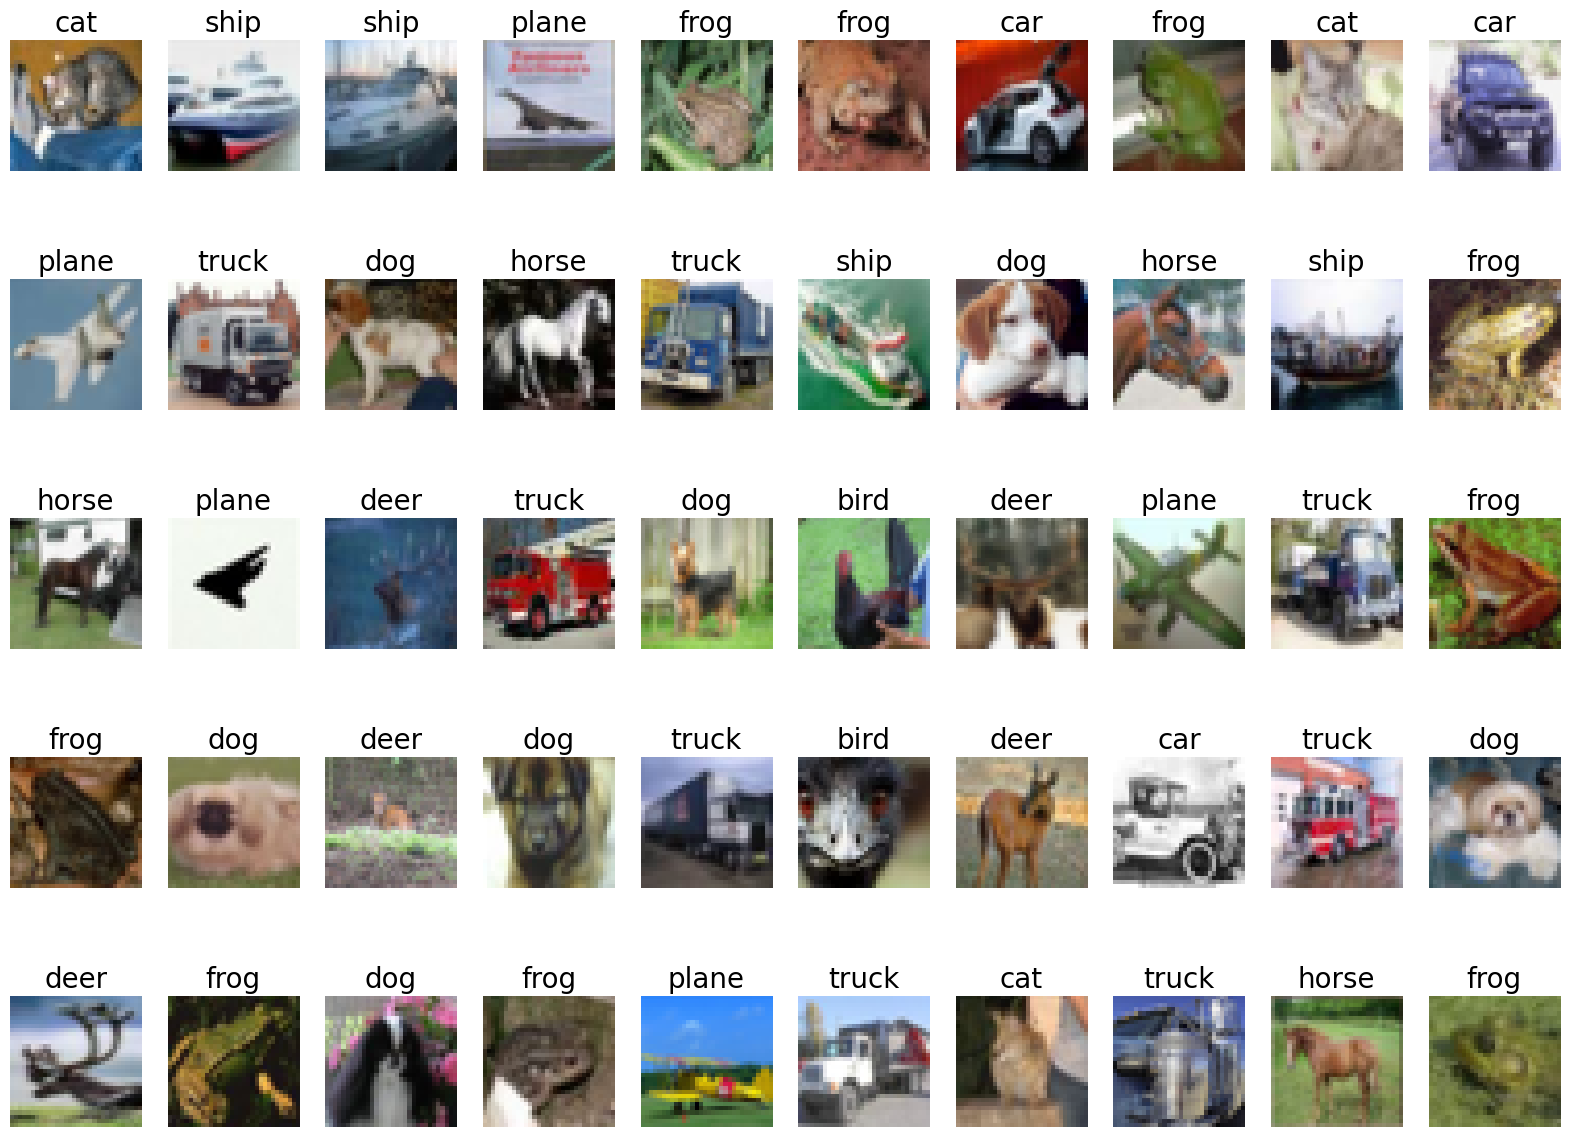

In [22]:

plt.figure(figsize=(20, 15))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    label_name = classes[labels[i]]
    
    # 텐서를 넘파이로 변환
    image_np = images[i].numpy().copy()
    # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
    img = np.transpose(image_np, (1, 2, 0))
    # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
    img = (img + 1)/2
    # 결과 표시
    ax.imshow(img)
    ax.set_title(label_name, fontsize=20)
    ax.set_axis_off()
plt.show()

### 학습용 파라미터 설정

In [23]:
# 입력 차원수는 3*32*32=3072
n_input = images1.shape[1]

# 출력 차원수
# 분류 클래스의 수이므로　10
n_output = len(set(labels1.data.numpy()))
# np.unique(labels1.data.numpy()).size
# 은닉층의 노드수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [24]:
# 모델 정의
# 3072입력 10출력 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층의 노드수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층의 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### 모델 인스턴스 생성과 GPU 할당

In [25]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [26]:
# 모델 개요 표시 1
print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [27]:
# 모델 개요 표시 2
summary(net, (100, 3072), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

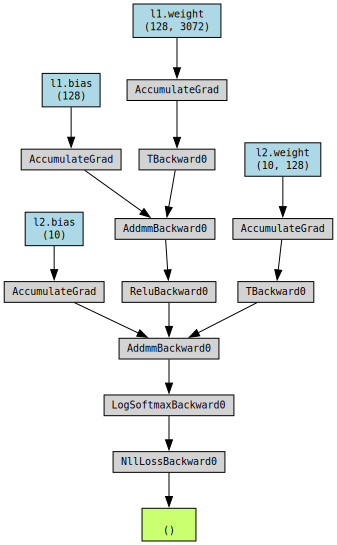

In [28]:
# eval_loss (손실 계산)
for images, labels in test_loader1:
    break
inputs = images.to(device)
labels = labels.to(device)

# 예측 계산
outputs = net(inputs)

    # 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 학습

In [30]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
# history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

In [31]:
# tqdm 라이브러리 임포트

from tqdm.notebook import tqdm

base_epochs = len(history) # => 0
batch_size_train = len(train_loader1)
batch_size_test = len(test_loader1)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 훈련 페이즈
    net.train() # dropout, batch normalization 활성화
    # count = 0

    for inputs, labels in tqdm(train_loader1):
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        train_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_train_loss = train_loss / batch_size_train
    avg_train_acc = train_acc / batch_size_train

    # 예측 페이즈
    net.eval()
    # count = 0

    for inputs, labels in test_loader1:
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        val_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_val_loss = val_loss / batch_size_test
    avg_val_acc = val_acc / batch_size_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.94852 acc: 0.31866 val_loss: 1.79165, val_acc: 0.37660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.73626 acc: 0.39500 val_loss: 1.68655, val_acc: 0.41430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.65341 acc: 0.42608 val_loss: 1.62475, val_acc: 0.43300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 1.60089 acc: 0.44426 val_loss: 1.58832, val_acc: 0.44920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 1.56181 acc: 0.45638 val_loss: 1.55537, val_acc: 0.45880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 1.53005 acc: 0.46906 val_loss: 1.53413, val_acc: 0.46510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 1.50245 acc: 0.47858 val_loss: 1.51218, val_acc: 0.47220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 1.47787 acc: 0.48856 val_loss: 1.49461, val_acc: 0.47580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 1.45452 acc: 0.49814 val_loss: 1.48058, val_acc: 0.47900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 1.43282 acc: 0.50624 val_loss: 1.46465, val_acc: 0.48410


### 평가

초기상태 : 손실 : 1.79165  정확도 : 0.37660
최종상태 : 손실 : 1.46465  정확도 : 0.48410


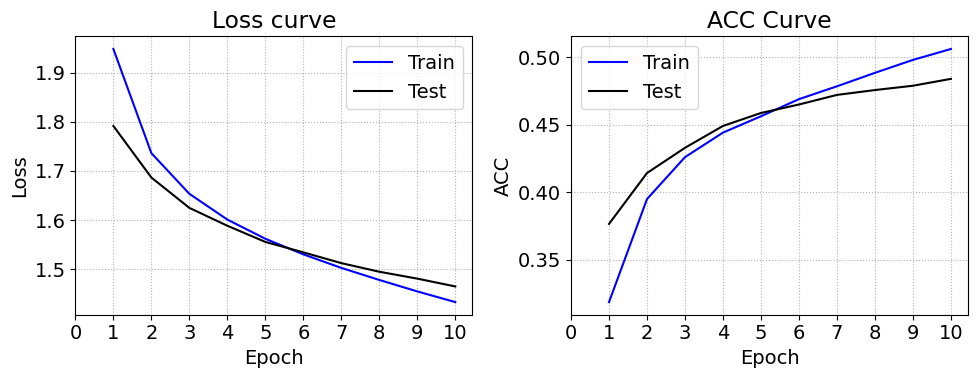

In [39]:
# 평가
# 손실과 정확도 확인
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

num_epochs = len(history)
unit = num_epochs / 10

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# 학습 곡선 출력(손실)
# plt.figure(figsize=(9,8))
axs[0].plot(history[:,0], history[:,1], 'b', label='Train')
axs[0].plot(history[:,0], history[:,3], 'k', label='Test')
axs[0].set_xticks(np.arange(0,num_epochs+1, unit))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss curve')
axs[0].legend()


# 학습 곡선 출력(정확도)
# plt.figure(figsize=(9,8))
axs[1].plot(history[:,0], history[:,2], 'b', label='Train')
axs[1].plot(history[:,0], history[:,4], 'k', label='Test')
axs[1].set_xticks(np.arange(0,num_epochs+1,unit))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ACC')
axs[1].set_title('ACC Curve')
axs[1].legend()

plt.tight_layout()
plt.show()

### 모델 정의(CNN)

In [47]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3     

### 모델 인스턴스 생성

In [48]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [49]:
# 모델 개요 표시 1

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [50]:
# 모델 개요 표시2

summary(net, (100,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         9,248
│    └─Conv2d: 2-1                       [100, 32, 30, 30]         896
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [100, 32, 30, 30]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [100, 32, 28, 28]         9,248
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [100, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [100, 32, 14, 14]         --
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [

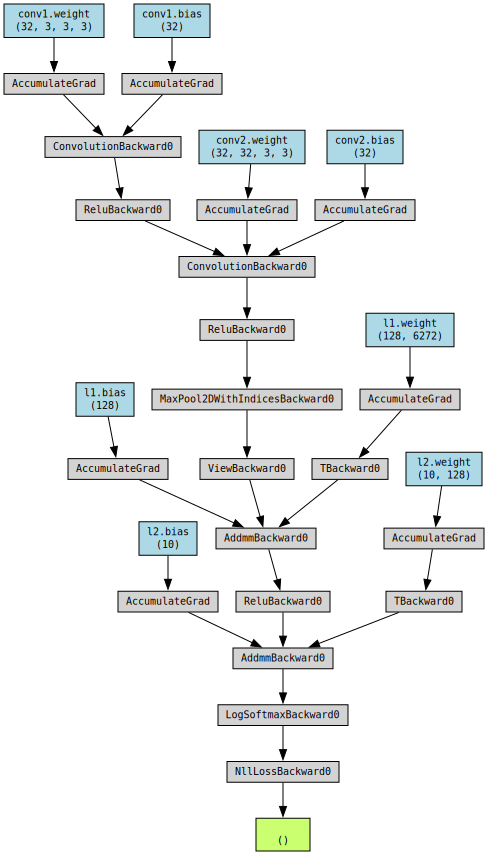

In [51]:
# eval_loss (손실 계산)
for images, labels in test_loader2:
    break
inputs = images.to(device)
labels = labels.to(device)

# 예측 계산
outputs = net(inputs)

    # 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 결과(CNN)

In [56]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history = np.zeros((0,5))

# 학습


In [57]:
# tqdm 라이브러리 임포트

from tqdm.notebook import tqdm

base_epochs = len(history) # => 0
batch_size_train = len(train_loader2)
batch_size_test = len(test_loader2)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 훈련 페이즈
    net.train() # dropout, batch normalization 활성화
    # count = 0

    for inputs, labels in tqdm(train_loader2):
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        train_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_train_loss = train_loss / batch_size_train
    avg_train_acc = train_acc / batch_size_train

    # 예측 페이즈
    net.eval()
    # count = 0

    for inputs, labels in test_loader2:
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        val_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_val_loss = val_loss / batch_size_test
    avg_val_acc = val_acc / batch_size_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history  = np.vstack((history, item))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 2.11263 acc: 0.24346 val_loss: 1.87121, val_acc: 0.34800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.78680 acc: 0.37280 val_loss: 1.70387, val_acc: 0.40730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.64394 acc: 0.42358 val_loss: 1.56349, val_acc: 0.45290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 1.54266 acc: 0.45622 val_loss: 1.48334, val_acc: 0.47640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 1.45846 acc: 0.48292 val_loss: 1.43935, val_acc: 0.48310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 1.38891 acc: 0.50642 val_loss: 1.39889, val_acc: 0.50630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 1.32848 acc: 0.53002 val_loss: 1.30514, val_acc: 0.53530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 1.27267 acc: 0.55294 val_loss: 1.28196, val_acc: 0.54000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 1.21596 acc: 0.57336 val_loss: 1.22179, val_acc: 0.56390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 1.16655 acc: 0.59232 val_loss: 1.21571, val_acc: 0.57160


### 평가

초기상태 : 손실 : 1.87121  정확도 : 0.34800
최종상태 : 손실 : 1.21571  정확도 : 0.57160


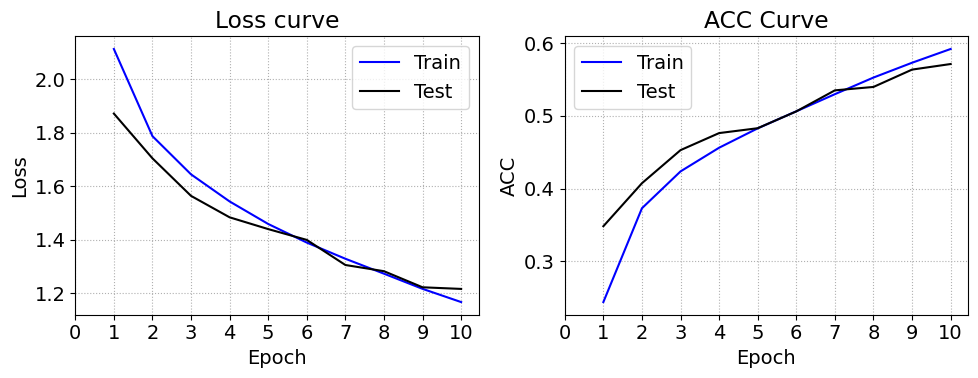

In [58]:

# 손실과 정확도 확인
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

num_epochs = len(history)
unit = num_epochs / 10

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# 학습 곡선 출력(손실)
# plt.figure(figsize=(9,8))
axs[0].plot(history[:,0], history[:,1], 'b', label='Train')
axs[0].plot(history[:,0], history[:,3], 'k', label='Test')
axs[0].set_xticks(np.arange(0,num_epochs+1, unit))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss curve')
axs[0].legend()


# 학습 곡선 출력(정확도)
# plt.figure(figsize=(9,8))
axs[1].plot(history[:,0], history[:,2], 'b', label='Train')
axs[1].plot(history[:,0], history[:,4], 'k', label='Test')
axs[1].set_xticks(np.arange(0,num_epochs+1,unit))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ACC')
axs[1].set_title('ACC Curve')
axs[1].legend()

plt.tight_layout()
plt.show()